# Importing required libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import xgboost as xgb
import sqlite3
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## Loading the dataset

In [0]:
#Read the final_features data frame
df_nlp = pd.read_csv("drive/My Drive/data/nlp_features_train.csv",encoding='latin-1')
df_ppro = pd.read_csv("drive/My Drive/data/df_fe_without_preprocessing_train.csv",encoding='latin-1')

df1 = df_nlp.drop(['qid1','qid2'],axis=1)
df2 = df_ppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

df  = df1.merge(df2, on='id',how='left')

In [3]:
print ("Minimum length of the questions in Question 1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in Question 2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [Question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [Question2] :", df[df['q2_n_words']== 1].shape[0])

print ("\nMaximum length of the questions in Question 1 : " , max(df['q1_n_words']))
print ("Maximum length of the questions in Question 2 : " , max(df['q2_n_words']))

print ("\nAverage length of the questions in Question 1 : " , np.mean(df['q1_n_words']))
print ("Average length of the questions in Question 2 : " , np.mean(df['q2_n_words']))

Minimum length of the questions in Question 1 :  1
Minimum length of the questions in Question 2 :  1
Number of Questions with minimum length [Question1] : 67
Number of Questions with minimum length [Question2] : 24

Maximum length of the questions in Question 1 :  125
Maximum length of the questions in Question 2 :  237

Average length of the questions in Question 1 :  10.94459175344431
Average length of the questions in Question 2 :  11.185119592371812


In [0]:
quora_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


- - -

## Basic Feature Extraction (before cleaning)


#### Let us now construct some basic features like:

* freq_qid1 = Frequency of qid1's
* freq_qid2 = Frequency of qid2's
* q1len = Length of Question 1
* q2len = Length of Question 2
* q1_n_words = Number of words in Question 1
* q2_n_words = Number of words in Question 2
* word_Common = (Number of common unique words in Question 1 and Question 2)
* word_Total = (Total num of words in Question 1 + Total num of words in Question 2)
* word_share = (word_common)/(word_Total)
* freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
* freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2





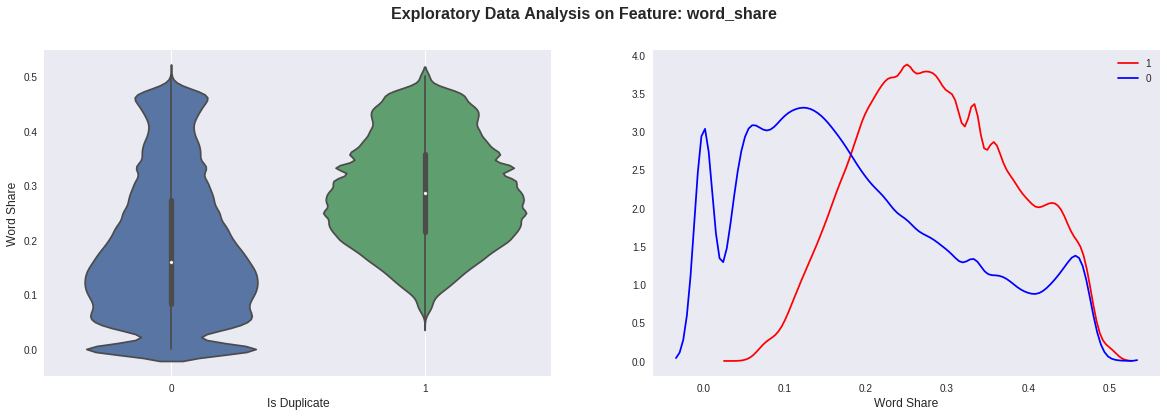

In [0]:
plt.figure(figsize=(20,6))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "word_share", data = df)
plt.xlabel("Is Duplicate",fontsize = 12)
plt.ylabel("Word Share",fontsize = 12)
plt.grid()

plt.subplot(122)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'], label = "1", color = "red", hist=False)
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'], label = "0", color = "blue", hist=False)
plt.xlabel("Word Share",fontsize = 12)
plt.ylabel("")
plt.legend()
plt.grid()

plt.suptitle("Exploratory Data Analysis on Feature: word_share",fontsize=16,fontweight="bold")
plt.show()

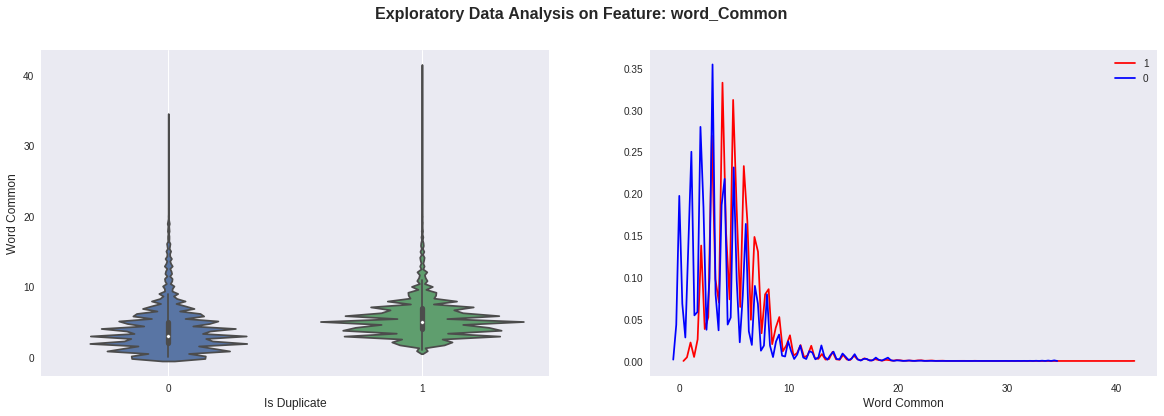

In [0]:
plt.figure(figsize=(20,6))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "word_Common", data = df)
plt.xlabel("Is Duplicate",fontsize = 12)
plt.ylabel("Word Common",fontsize = 12)
plt.grid()

plt.subplot(122)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'], label = "1", color = "red", hist=False)
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'], label = "0", color = "blue", hist=False)
plt.xlabel("Word Common",fontsize = 12)
plt.ylabel("")
plt.legend()
plt.grid()

plt.suptitle("Exploratory Data Analysis on Feature: word_Common",fontsize=16,fontweight="bold")
plt.show()

## Observations:

* It could be observed from the plot that "word_share" is an important feature.
* Word common feature is highly overlapping for matching and non-matching questions.




- - -

## Advanced Feature Extraction (NLP and Fuzzy Features)


#### Definition:

* Token: We get a token by splitting sentence with a space
* Stop_Word : stop words as per NLTK.
* Word : A token that is not a stop_word

#### Token Features:

* cwc_min : Ratio of common_word_count to min length of word count of Q1 and Q2 
* cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) 
* cwc_max : Ratio of common_word_count to max length of word count of Q1 and Q2 
* cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) 
* csc_min : Ratio of common_stop_count to min length of stop count of Q1 and Q2 
* csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) 
* csc_max : Ratio of common_stop_count to max length of stop count of Q1 and Q2
* csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) 
* ctc_min : Ratio of common_token_count to min length of token count of Q1 and Q2
* ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens)) 
* ctc_max : Ratio of common_token_count to max length of token count of Q1 and Q2
* ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens)) 
* last_word_eq : Check if First word of both questions is equal or not
* last_word_eq = int(q1_tokens[-1] == q2_tokens[-1]) 
* first_word_eq : Check if First word of both questions is equal or not
* first_word_eq = int(q1_tokens[0] == q2_tokens[0]) 
* abs_len_diff : Abs. length difference
* abs_len_diff = abs(len(q1_tokens) - len(q2_tokens)) 
* mean_len : Average Token Length of both Questions
* mean_len = (len(q1_tokens) + len(q2_tokens))/2 


#### Fuzzy and NLP Features: 

* fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 
* fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 
* token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 
* token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 
* longest_substr_ratio : Ratio of length longest common substring to min length of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


###  Pair plot of 'ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'  features.


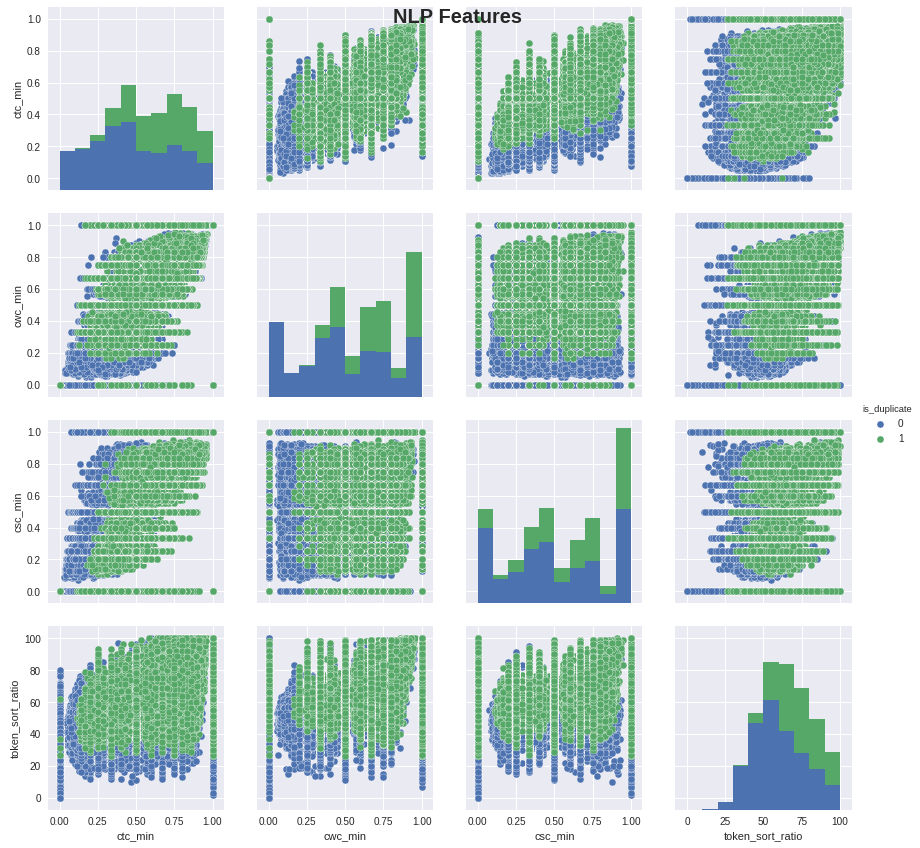

In [5]:

sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'],size = 3)
plt.suptitle("NLP Features",weight = 'bold').set_fontsize('20')
plt.show()

- - -

### EDA on  "token_sort_ratio" feature

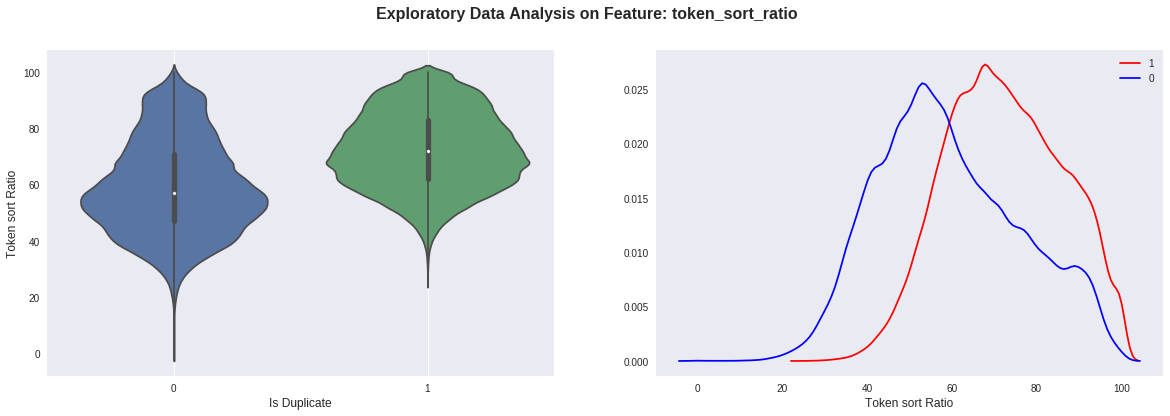

In [0]:
plt.figure(figsize=(20,6))

plt.subplot(121)
sns.violinplot(x = "is_duplicate", y = "token_sort_ratio", data = df)
plt.xlabel("Is Duplicate",fontsize = 12)
plt.ylabel("Token sort Ratio",fontsize = 12)
plt.grid()

plt.subplot(122)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'], label = "1", color = "red", hist=False)
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'], label = "0", color = "blue", hist=False)
plt.xlabel("Token sort Ratio",fontsize = 12)
plt.ylabel("")
plt.legend()
plt.grid()

plt.suptitle("Exploratory Data Analysis on Feature: token_sort_ratio",fontsize=16,fontweight="bold")
plt.show()

### Observations:
* It could be observed from the pair-plot that the features ctc_min,csc_min and token_sort_ratio are useful for classfication.

- - -

## TSNE Visualization in 2D space.

In [0]:
from sklearn.preprocessing import MinMaxScaler


df_sample = df[0:20000]
X = MinMaxScaler().fit_transform(df_sample[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
Y = df_sample['is_duplicate'].values

In [0]:
tsne2d = TSNE(
    n_components=2,
    perplexity = 40,
    init='random',
    random_state=42,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.114s...
[t-SNE] Computed neighbors for 20000 samples in 3.734s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

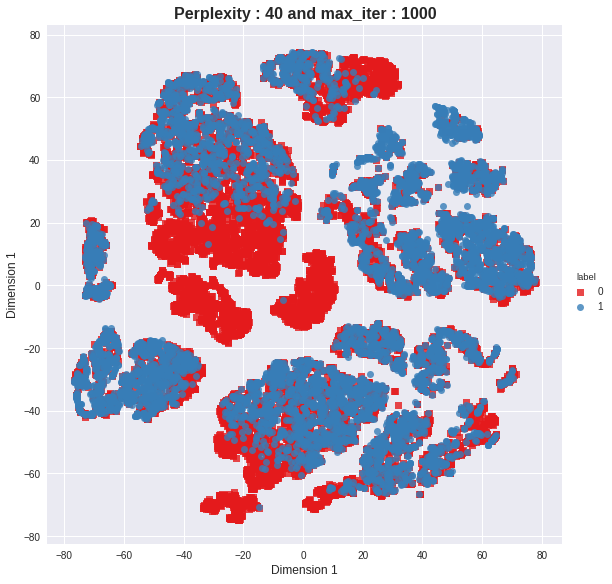

In [0]:
tsne_2d = pd.DataFrame({'x':tsne_2d[:,0], 'y':tsne_2d[:,1] ,'label':Y})


sns.lmplot(data=tsne_2d_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("Perplexity : {} and max_iter : {}".format(40, 1000),fontsize = 16,fontweight = 'bold')
plt.xlabel("Dimension 1",fontsize = 12)
plt.ylabel("Dimension 1",fontsize = 12)
plt.show()

## TSNE Visualization in 3D Space

In [0]:

tsne3d = TSNE(
    n_components=3,
    perplexity = 40,
    init='random',
    random_state=42,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)


x,y,z = tsne3d[:,0].tolist(),tsne3d[:,1].tolist(),tsne3d[:,2].tolist()
tsne_3d = pd.DataFrame(
    {'X Label': x,
     'Y Label': y,
     'Z Label': z,
     'Label': Y.tolist()
    })

tsne3d_0 = tsne_3d.loc[tsne_3d['Label'] == 0]
tsne3d_1 = tsne_3d.loc[tsne_3d['Label'] == 1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.110s...
[t-SNE] Computed neighbors for 20000 samples in 3.716s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

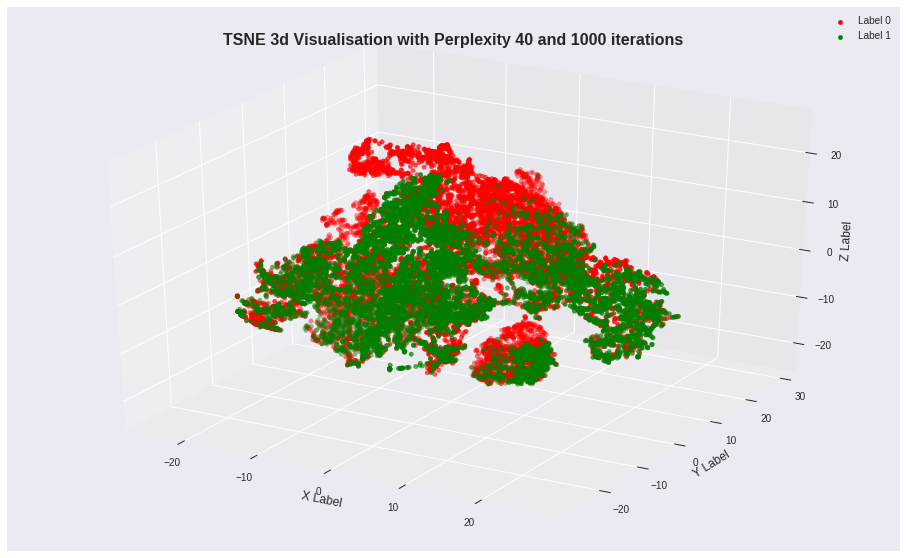

In [0]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne3d_0['X Label'], tsne3d_0['Y Label'], tsne3d_0['Z Label'],c ='r',label='Label 0', marker='o')
ax.scatter(tsne3d_1['X Label'], tsne3d_1['Y Label'], tsne3d_1['Z Label'],c = 'g',label='Label 1', marker='o')
ax.set_xlabel('X Label',fontsize = 12)
ax.set_ylabel('Y Label',fontsize = 12)
ax.set_zlabel('Z Label',fontsize = 12)
ax.set_title("TSNE 3d Visualisation with Perplexity 40 and 1000 iterations",fontsize = 16,fontweight ='bold')
ax.legend()

plt.show()

- - -

In [0]:
#Remove the first row 
#data.drop(data.index[0], inplace=True)
y_true = df['is_duplicate']
df.drop(['id','is_duplicate'], axis=1, inplace=True)

# Train-Test Split(70-30)

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)


In [0]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 28)
Number of data points in test data : (121287, 28)


In [0]:
X_train.head()

,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
65473,why is pm modi silent on current cauvery river...,why did narendra modi tell that he can not get...,0.624992,0.555549,0.333322,0.142855,0.545450,0.374998,1.0,1.0,...,1,61,86,11,15,6.0,26.0,0.230769,4,2
121619,what are the best exercises for sciatica,what is the best exercise for sciatica,0.666644,0.666644,0.749981,0.749981,0.714276,0.714276,1.0,1.0,...,1,41,38,7,6,4.0,13.0,0.307692,2,0
237345,what are some good post graduate diploma cours...,being female is it sin to loose virginity bef...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1,59,110,10,21,0.0,30.0,0.000000,2,0
49760,how should i improve my writing skill for blog...,how do i improve my writing,0.999950,0.499988,0.749981,0.599988,0.833319,0.555549,0.0,1.0,...,11,51,28,9,6,4.0,15.0,0.266667,23,1
33134,what thought scares you the most,what scares you most in life,0.499975,0.499975,0.749981,0.749981,0.666656,0.666656,0.0,1.0,...,3,33,29,6,6,3.0,12.0,0.250000,4,2


- - - 

<h2>Converting text into tf-idf vectors</h2>

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(lowercase = False,ngram_range = (1,1))

train_q1 = tfidf.fit_transform(X_train['question1'].values.astype('U'))
test_q1 = tfidf.transform(X_test['question1'].values.astype('U'))


tfidf_2 = TfidfVectorizer(lowercase = False,ngram_range = (1,1))

train_q2 = tfidf_2.fit_transform(X_train['question2'].values.astype('U'))
test_q2 = tfidf_2.transform(X_test['question2'].values.astype('U'))


- - -

<h3>Combining tf-idf vectors to the train and test set</h3>

In [0]:
train_tfidf = hstack((train_q1,train_q2))
test_tfidf = hstack((test_q1,test_q2))

In [0]:
X_train.drop(['question1','question2'], axis=1, inplace=True)
X_test.drop(['question1','question2'], axis=1, inplace=True)

In [0]:
from scipy.sparse import hstack

X_train = hstack((X_train,train_tfidf)).tocsr()
X_test = hstack((X_test, test_tfidf)).tocsr()

- - -

# Plot Confusion Matrix

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 

    labels = [1,2]
    # representing A in heatmap format

    print("-"*20, "Confusion matrix", "-"*20)

    plt.figure(figsize=(20,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,4))

    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format

    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,4))

    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<h2> Building a random model (Finding worst-case log-loss) </h2>


Log loss on Test Data using Random Model 0.8882239477903591
-------------------- Confusion matrix --------------------


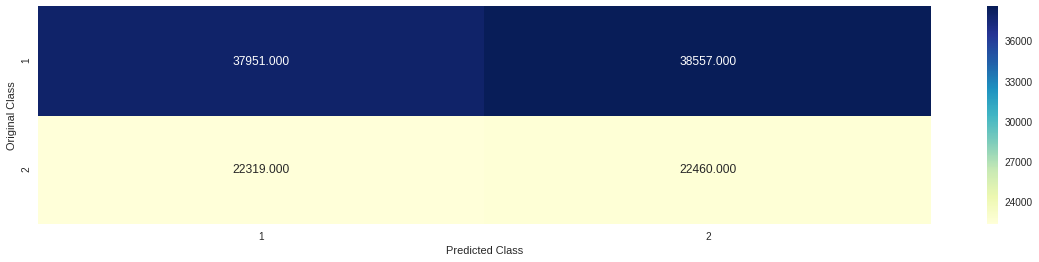

-------------------- Precision matrix (Columm Sum=1) --------------------


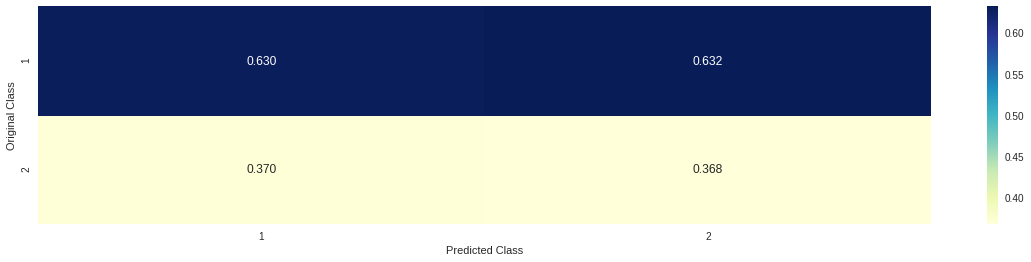

-------------------- Recall matrix (Row sum=1) --------------------


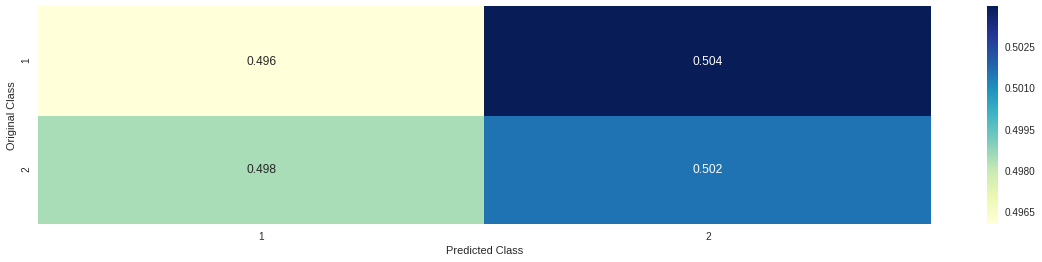

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data

test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

- - -

<h2> Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4439796694227767
For values of alpha =  0.0001 The log loss is: 0.4468034039376788
For values of alpha =  0.001 The log loss is: 0.4449445109475069
For values of alpha =  0.01 The log loss is: 0.44650913615226545
For values of alpha =  0.1 The log loss is: 0.463411351356397
For values of alpha =  1 The log loss is: 0.49307446604994093
For values of alpha =  10 The log loss is: 0.545470555119209


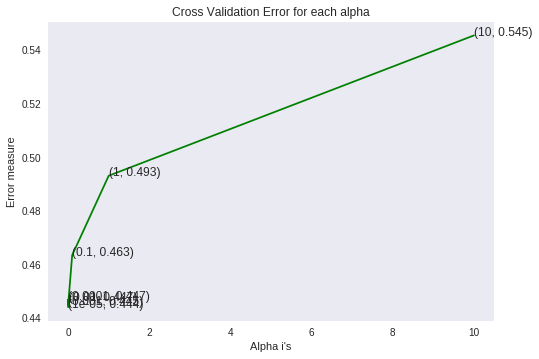

For values of best alpha =  1e-05 The train log loss is: 0.44415035961499355
For values of best alpha =  1e-05 The test log loss is: 0.4439796694227767
Total number of data points : 121287
-------------------- Confusion matrix --------------------


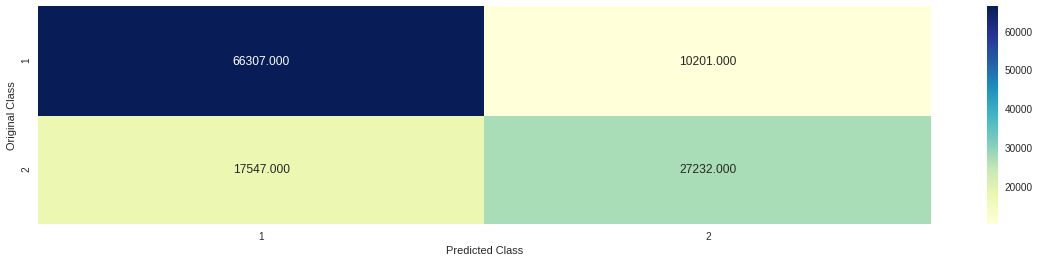

-------------------- Precision matrix (Columm Sum=1) --------------------


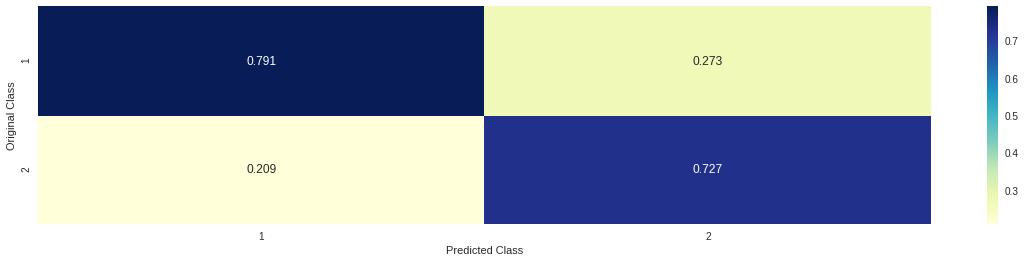

-------------------- Recall matrix (Row sum=1) --------------------


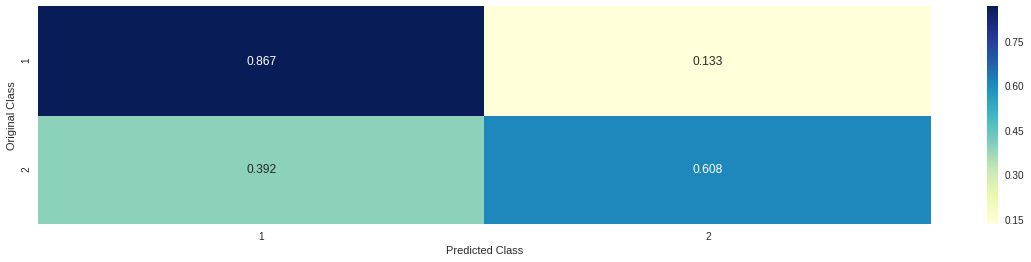

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

- - -

<h2> Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.44599685806841227
For values of alpha =  0.0001 The log loss is: 0.4747449068369659
For values of alpha =  0.001 The log loss is: 0.5017616008675261
For values of alpha =  0.01 The log loss is: 0.515514548003781
For values of alpha =  0.1 The log loss is: 0.49445462910068994
For values of alpha =  1 The log loss is: 0.5799429173069095
For values of alpha =  10 The log loss is: 0.6067385838764973


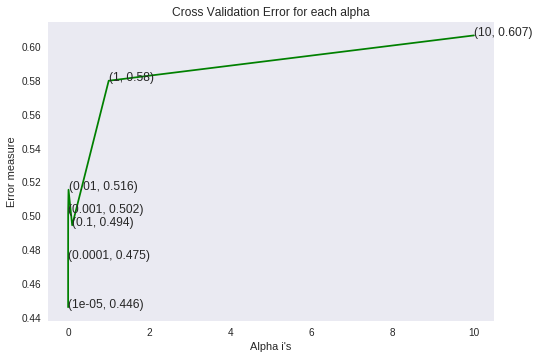

For values of best alpha =  1e-05 The train log loss is: 0.4467445707346612
For values of best alpha =  1e-05 The test log loss is: 0.44599685806841227
Total number of data points : 121287
-------------------- Confusion matrix --------------------


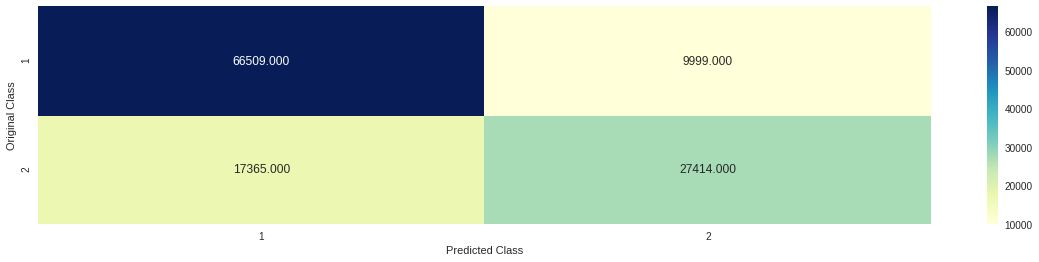

-------------------- Precision matrix (Columm Sum=1) --------------------


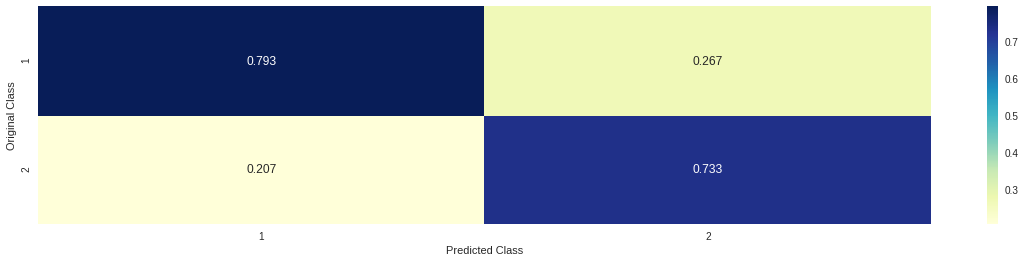

-------------------- Recall matrix (Row sum=1) --------------------


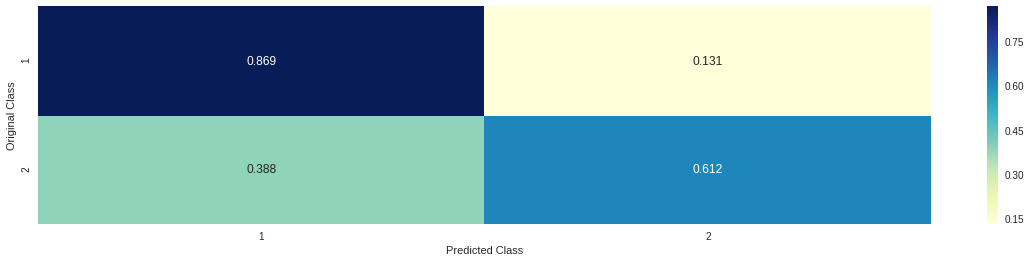

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

- - -

In [0]:
clf = SGDClassifier(alpha=10, penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)

SGDClassifier(alpha=10, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

- - -

<h1> XGBoost with hyperparameter tuning </h1>

In [0]:
params = {}

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

<h3>Tuning Xgboost for max_depth and min_child_weight</h3>

In [0]:

min_logloss = float("Inf")

params_grid = [
    (max_depth, min_child_weight)
    for max_depth in range(2, 10,2)
    for min_child_weight in range(1, 6)
]

best_params = None

for max_depth, min_child_weight in params_grid:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        d_train,
        seed=42,
        nfold=10,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth,min_child_weight)

CV with max_depth=2, min_child_weight=1
	LogLoss 0.4294156 for 9 rounds
CV with max_depth=2, min_child_weight=2
	LogLoss 0.4294156 for 9 rounds
CV with max_depth=2, min_child_weight=3
	LogLoss 0.4294156 for 9 rounds
CV with max_depth=2, min_child_weight=4
	LogLoss 0.4294156 for 9 rounds
CV with max_depth=2, min_child_weight=5
	LogLoss 0.4294156 for 9 rounds
CV with max_depth=4, min_child_weight=1
	LogLoss 0.37871869999999996 for 9 rounds
CV with max_depth=4, min_child_weight=2
	LogLoss 0.3787198 for 9 rounds
CV with max_depth=4, min_child_weight=3
	LogLoss 0.3786943 for 9 rounds
CV with max_depth=4, min_child_weight=4
	LogLoss 0.3786967 for 9 rounds
CV with max_depth=4, min_child_weight=5
	LogLoss 0.37869359999999996 for 9 rounds
CV with max_depth=6, min_child_weight=1
	LogLoss 0.3588859999999999 for 9 rounds
CV with max_depth=6, min_child_weight=2
	LogLoss 0.3592299 for 9 rounds
CV with max_depth=6, min_child_weight=3
	LogLoss 0.35934049999999995 for 9 rounds
CV with max_depth=6, min_

In [0]:
print("Best params Max depth is {}, and Minimum child weight is {}.".format(best_params[0], best_params[1]))


Best params for Max depth is 8, and Minimum child weight is 4.


<h3> Tuning Xgboost for regularization alpha</h3>

In [0]:
min_logloss = float("Inf")
best_params2 = None


for reg_alpha in [1e-5, 1e-3, 0.1, 1, 100]:
    print("CV with reg_alpha={}".format(reg_alpha))

    # We update our parameters
    params['reg_alpha'] = reg_alpha

    # Run and time CV
    cv_results = xgb.cv(
            params,
            d_train,
            seed=42,
            nfold=10,
            metrics=['logloss'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params2 = reg_alpha

# best reg_alpha        
print("Best params: {}".format(best_params2))

CV with reg_alpha=1e-05
	LogLoss 0.3467468 for 9 rounds
CV with reg_alpha=0.001
	LogLoss 0.34685049999999995 for 9 rounds
CV with reg_alpha=0.1
	LogLoss 0.34659829999999997 for 9 rounds
CV with reg_alpha=1
	LogLoss 0.34680690000000003 for 9 rounds
CV with reg_alpha=100
	LogLoss 0.35983519999999997 for 9 rounds
Best params: 0.1


<h3>Training on the best parameters</h3>

In [0]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 8
params['min_child_weight'] = 4
params['reg_alpha'] = 0.1

#d_train = xgb.DMatrix(X_train, label=y_train)
#d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.683129	valid-logloss:0.683147
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.601379	valid-logloss:0.601512
[20]	train-logloss:0.542975	valid-logloss:0.543334
[30]	train-logloss:0.499509	valid-logloss:0.500183
[40]	train-logloss:0.466527	valid-logloss:0.467561
[50]	train-logloss:0.440822	valid-logloss:0.442411
[60]	train-logloss:0.420302	valid-logloss:0.422371
[70]	train-logloss:0.404037	valid-logloss:0.40667
[80]	train-logloss:0.391014	valid-logloss:0.394235
[90]	train-logloss:0.38073	valid-logloss:0.38439
[100]	train-logloss:0.372049	valid-logloss:0.37616
[110]	train-logloss:0.364737	valid-logloss:0.369352
[120]	train-logloss:0.358548	valid-logloss:0.36364
[130]	train-logloss:0.35342	valid-logloss:0.359019
[140]	train-logloss:0.349088	valid-logloss:0.355172
[150]	train-logloss:0.345435	valid-logloss:0.351937
[160]	train-logloss:0.342323	valid

Total number of data points : 121287
-------------------- Confusion matrix --------------------


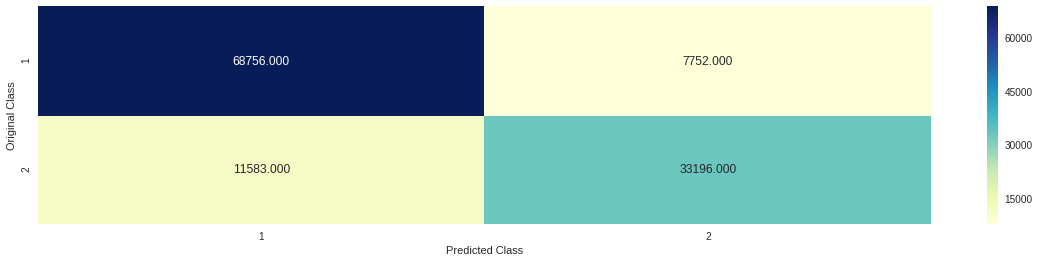

-------------------- Precision matrix (Columm Sum=1) --------------------


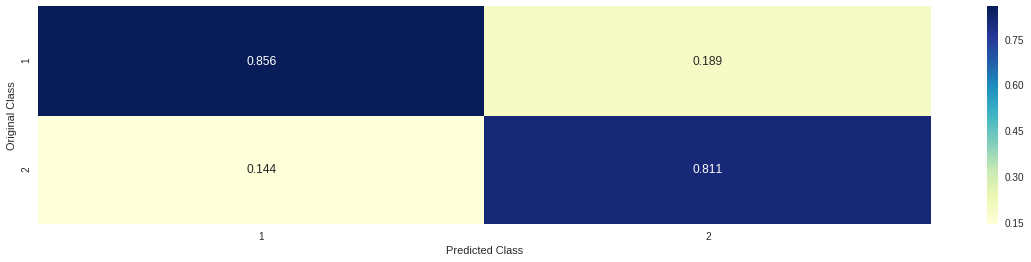

-------------------- Recall matrix (Row sum=1) --------------------


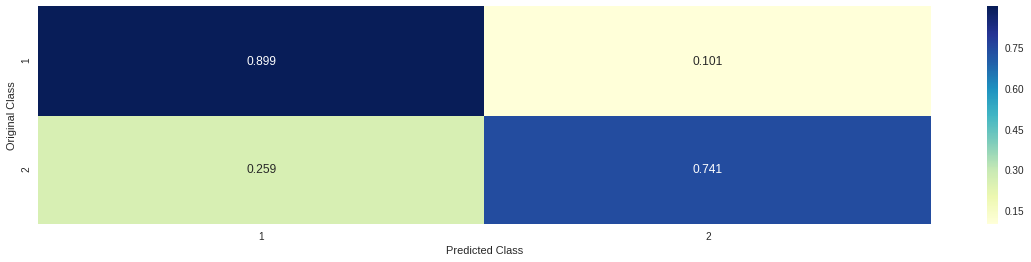

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Conclusion



*   Started by running a random model which produced a test loss of 0.88.So our model should perform significantly better than this to get required results since the cost of misclassification for this problem is high.
*   Tried Logistic Regression with hyperparameter tuning which led to test loss of 0.44 along with linear-SVM with hyperparameter tuning which led to test log-loss of 0.44 as well.
*    Performed XGBoost with hyper-parameter tuning to get a significant improvement over previous two models yielding a test loss of 0.32.



*   Tuning the parameters of xgboost improves the model.
*   Log loss is reduced to 0.328 which is a significant improvement over the logistic regression and linear SVM models.







In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Log-Loss"]

x.add_row(["Random", 0.888])
x.add_row(["Logistic Regression", 0.443])
x.add_row(["Linear SVM", 0.441])
x.add_row(["XGBoost", 0.328])

print(x)

+---------------------+----------+
|        Model        | Log-Loss |
+---------------------+----------+
|        Random       |  0.888   |
| Logistic Regression |  0.443   |
|      Linear SVM     |  0.441   |
|       XGBoost       |  0.328   |
+---------------------+----------+
